# Analysis of Anthologies

This is an analysis of text matching data on the corpus of three Eliot quote anthologies. 

In [2]:
import spacy
import pandas as pd
%matplotlib inline
from ast import literal_eval
import numpy as np
import re
import json
from nltk.corpus import names
from collections import Counter
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [16, 6]
plt.style.use('ggplot')

In [3]:
nlp = spacy.load('en')

In [4]:
with open('../middlemarch.txt') as f: 
    mm = f.read()

In [5]:
textALength = len(mm) 

In [6]:
# Get chapter locations
chapterMatches = re.finditer('PRELUDE|CHAPTER|FINALE', mm)
chapterLocations = [match.start() for match in chapterMatches]
chapterLocations.append(textALength) # Add one to account for last chunk. 
len(chapterLocations)

89

In [7]:
def getChapters(text): 
    chapters = []
    for i, loc in enumerate(chapterLocations): 
        if i != len(chapterLocations)-1: 
            chapter = mm[loc:chapterLocations[i+1]]
            chapters.append(chapter)
    return chapters

In [22]:
chapters = getChapters(mm)
chapterLengths = [len(nlp(chapter, tag=False, parse=False, entity=False)) for chapter in chapters]
chapterLengthsSeries = pd.Series(chapterLengths)
# chapterLengthsSeries.plot(kind='bar', title='Chapter Lengths')

In [9]:
with open('../txt/anthologies.json') as f: 
    rawData = f.read()

In [10]:
df = pd.read_json(rawData)

In [11]:
sum([len(item) for item in df['Locations in A'].values])

60

In [12]:
def diachronicAnalysis(df, decades=(1950, 2020), bins=chapterLocations, useWordcounts=True):
    """ Turning on useWordcounts makes it so that it's weighted by wordcount. 
    Turning it off uses raw numbers of quotations. """
    decades = np.arange(decades[0], decades[1], 10)
    # Make a dictionary of decades. 
    # Values are a list of locations.  
    decadeDict = {}
    for i, row in df.iterrows():
        decade = row['Decade']
        locationsAndWordcounts = row['Locations in A with Wordcounts']
        if decade not in decadeDict: 
            decadeDict[decade] = locationsAndWordcounts
        else: 
            decadeDict[decade] += locationsAndWordcounts
    # Grab the beginnings of quotes. 
    decadeStartsWeights = {decade: [(item[0][0], item[1]) 
                                    for item in loc] 
                    for decade, loc in decadeDict.items()}
    if useWordcounts: 
        decadesBinned = {decade: 
                     np.histogram([loc[0] for loc in locations], 
                                  bins=bins,
                                  weights=[loc[1] for loc in locations],
                                  range=(0, textALength))[0]
                     for decade, locations in decadeStartsWeights.items() 
                         if decade in decades}
    else: 
        decadesBinned = {decade: 
                     np.histogram([loc[0] for loc in locations], 
                                  bins=bins,
                                  range=(0, textALength))[0]
                     for decade, locations in decadeStartsWeights.items() 
                         if decade in decades}
    decadesDF = pd.DataFrame(decadesBinned).T
    #Normalize
    decadesDF = decadesDF.div(decadesDF.max(axis=1), axis=0)
    return decadesDF

def countWords(locRange): 
    """ Counts words in middlemarch, given character ranges. """
    doc = nlp(mm[locRange[0]:locRange[1]], tag=False, parse=False, entity=False)
    return len(doc)

def totalWords(locRangeSet): 
    """ Counts total words in a list of location ranges. """
    return sum([countWords(locRange) for locRange in locRangeSet])    
    
def countsPerSet(locRangeSet): 
    """ Returns an augmented location range set that includes word counts. """
    return [(locRange, countWords(locRange))
             for locRange in locRangeSet]
    
def extractWordcounts(locsAndWordcounts): 
    """ 
    Takes pairs of location ranges and wordcounts, 
    and returns just the wordcounts. 
    """
    return [item[1] for item in locsAndWordcounts 
            if len(locsAndWordcounts) > 0]

def synchronicAnalysis(df, bins=chapterLocations, useWordcounts=True): 
    locs = df['Locations in A'].values
    locCounts = [(loc, countWords(loc)) for locSet in locs
              for loc in locSet]
    starts = [loc[0][0] for loc in locCounts]
    counts = [loc[1] for loc in locCounts]
    if useWordcounts: 
        binned = np.histogram(starts, bins=bins, 
                              weights=counts, range=(0, textALength))
    else: 
        binned = np.histogram(starts, bins=bins, 
                              range=(0, textALength))
    binnedDF = pd.Series(binned[0])
    return binnedDF

def plotDiachronicAnalysis(df): 
    ylabels = [str(int(decade)) for decade in df.index] + ['2020']
    plt.pcolor(df, cmap='gnuplot')
    plt.yticks(np.arange(len(df.index)+1), ylabels)
    plt.gca().invert_yaxis()
    plt.ylabel('Decade')
    plt.xlabel('Chapter')
    plt.gca().set_xlim((0, len(df.T)))
    plt.colorbar(ticks=[])
    plt.show()
    
def plotSynchronicAnalysis(s, useWordcounts=True): 
    ax = s.plot(kind='bar')
    ax.set_xlabel('Chapter')
    if useWordcounts: 
        ax.set_ylabel('Number of Words Quoted')
    else: 
        ax.set_ylabel('Number of Quotations')

In [13]:
df['Quoted Words'] = df['Locations in A'].apply(totalWords)

In [14]:
df['Locations in A with Wordcounts'] = df['Locations in A'].apply(countsPerSet)

# Quotation Length Statistics

In [15]:
df['Wordcounts'] = df['Locations in A with Wordcounts'].apply(extractWordcounts)

In [16]:
df['Wordcounts'].values

array([[17, 17, 49, 19], [55, 22, 14, 35, 49, 18, 29, 101, 42, 47, 98, 48],
       [145, 94, 93, 220, 192, 47, 262, 153, 99, 38, 77, 32, 113, 99, 241, 25, 111, 39, 36, 35, 115, 33, 73, 19, 23, 68, 104, 54, 91, 118, 44, 41, 146, 36, 121, 50, 67, 205, 35, 63, 39, 42, 54, 128]], dtype=object)

In [17]:
wordcounts = []
for countSet in df['Wordcounts'].values: 
    for count in countSet: 
        wordcounts.append(count)

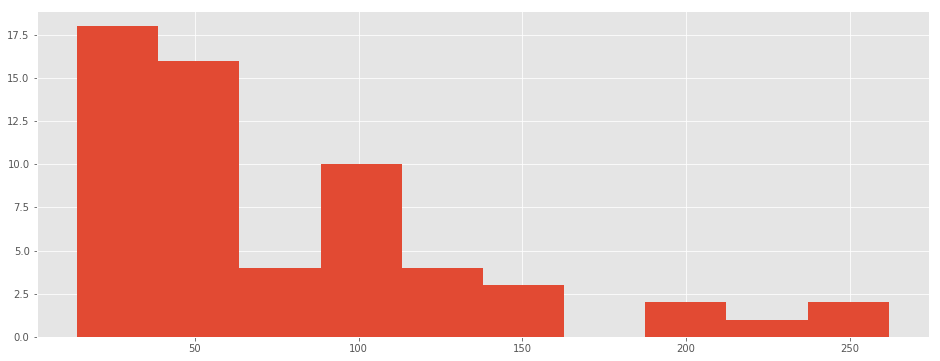

In [18]:
pd.Series(wordcounts).hist()

# Number of Quotes (and words Quoted) by Chapter

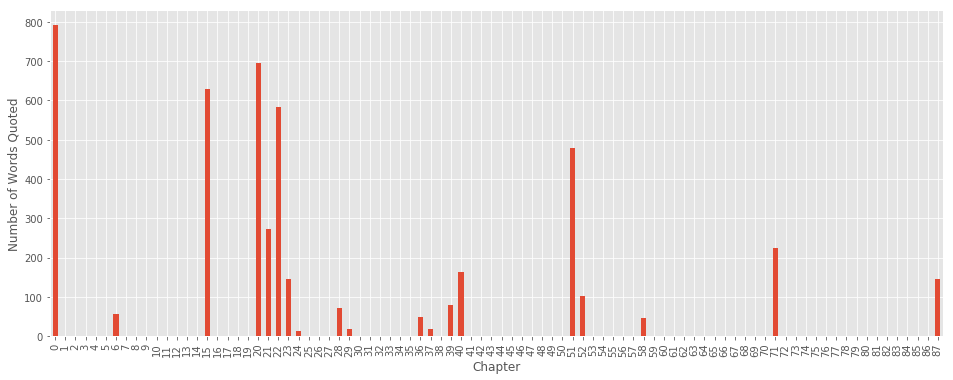

In [19]:
plotSynchronicAnalysis(synchronicAnalysis(df))

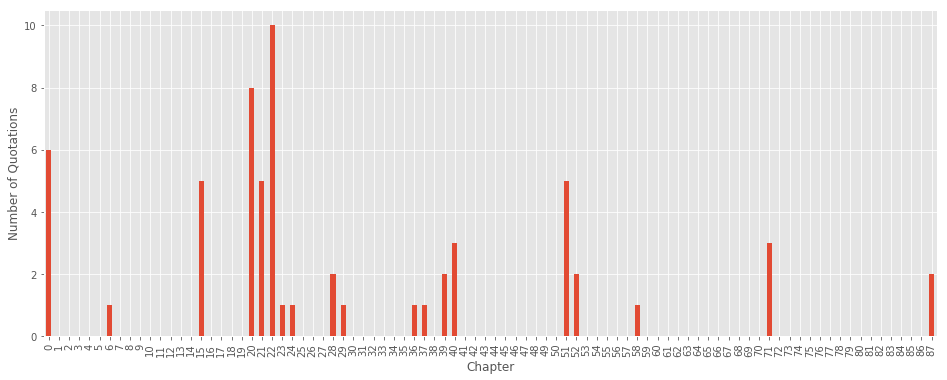

In [20]:
plotSynchronicAnalysis(synchronicAnalysis(df, useWordcounts=False), useWordcounts=False)

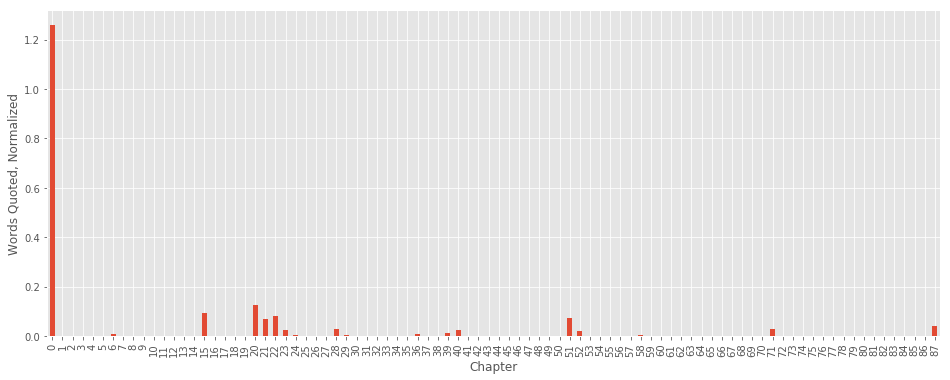

In [21]:
# Adjusted for the number of words in each chapter
ax = (synchronicAnalysis(df) / chapterLengthsSeries).plot(kind='bar')
ax.set_xlabel('Chapter')
ax.set_ylabel('Words Quoted, Normalized')